<a href="https://colab.research.google.com/github/FishyDanny/Road-Safety-Risk-Prediction/blob/main/03_hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import joblib
!pip install keras-tuner -q
import keras_tuner as kt
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay
import shutil
import os

In [ ]:
# Define the tuner directory
first_tuner_dir = '/content/drive/MyDrive/ACTL3143_project/tuning/first_model'
second_tuner_dir = '/content/drive/MyDrive/ACTL3143_project/tuning/second_model'

# Check if the directory exists and remove it
if os.path.exists(first_tuner_dir):
    shutil.rmtree(first_tuner_dir)
    print(f"Removed existing tuner directory: {first_tuner_dir}")
else:
    print(f"Tuner directory not found: {first_tuner_dir}")

if os.path.exists(second_tuner_dir):
    shutil.rmtree(second_tuner_dir)
    print(f"Removed existing tuner directory: {second_tuner_dir}")
else:
    print(f"Tuner directory not found: {second_tuner_dir}")

Removed existing tuner directory: /content/drive/MyDrive/ACTL3143_project/tuning/first_model
Tuner directory not found: /content/drive/MyDrive/ACTL3143_project/tuning/second_model


In [ ]:
drive.mount('/content/drive')

# Import data
X_train = joblib.load('/content/drive/MyDrive/ACTL3143_project/processed/X_train.pkl')
X_val = joblib.load('/content/drive/MyDrive/ACTL3143_project/processed/X_val.pkl')
y_train = joblib.load('/content/drive/MyDrive/ACTL3143_project/processed/y_train.pkl')
y_val = joblib.load('/content/drive/MyDrive/ACTL3143_project/processed/y_val.pkl')
X_test = joblib.load('/content/drive/MyDrive/ACTL3143_project/processed/X_test.pkl')
y_test = joblib.load('/content/drive/MyDrive/ACTL3143_project/processed/y_test.pkl')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
keras.utils.set_random_seed(42)

In [ ]:
def build_first_model_tuned(hp):
    model = keras.Sequential()
    model.add(layers.BatchNormalization(input_shape=(X_train.shape[1],)))

    # Tune number of layers and units
    for i in range(hp.Int('num_layers', 1, 4)):
        model.add(layers.Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
            activation='relu'
        ))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(
            rate=hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.6, step=0.1)
        ))

    model.add(layers.Dense(1, activation='sigmoid'))

    # Tune learning rate
    learning_rate = hp.Float('lr', min_value=1e-4, max_value=1e-3, sampling='log')

    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=learning_rate,
            clipnorm=1.0
        ),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(name='auc')]
    )
    return model

# Set up tuner
first_tuner = kt.BayesianOptimization(
    build_first_model_tuned,
    objective='val_auc',
    max_trials=15,
    directory='/content/drive/MyDrive/ACTL3143_project/tuning',
    project_name='first_model'
)

first_tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[keras.callbacks.EarlyStopping(patience=3)]
)

# Get best model
best_first_model = first_tuner.get_best_models(num_models=1)[0]

Trial 15 Complete [00h 01m 26s]
val_auc: 0.7994522452354431

Best val_auc So Far: 0.8006281852722168
Total elapsed time: 00h 16m 48s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
def build_second_model_tuned(hp):
    inputs = keras.Input(shape=(X_train.shape[1],))
    x = layers.Dense(
        hp.Int('initial_units', 64, 256, step=32),
        activation='relu'
    )(inputs)
    x = layers.BatchNormalization()(x)

    # Tune residual blocks
    for i in range(hp.Int('num_blocks', 1, 4)):
        residual = x
        units = hp.Int(f'block_{i}_units', 64, 512, step=64)

        x = layers.Dense(units, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(
            hp.Float(f'dropout_{i}', 0.1, 0.6, step=0.1)
        )(x)
        x = layers.Dense(residual.shape[-1])(x)
        x = layers.add([x, residual])
        x = layers.Activation('relu')(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    # Tune learning rate
    learning_rate = hp.Float('lr', min_value=1e-4, max_value=1e-3, sampling='log')

    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=learning_rate,
            clipnorm=1.0
        ),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(name='auc')]
    )
    return model

# Set up tuner
second_tuner = kt.BayesianOptimization(
    build_second_model_tuned,
    objective='val_auc',
    max_trials=15,
    directory='/content/drive/MyDrive/ACTL3143_project/tuning',
    project_name='second_model'
)

second_tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[keras.callbacks.EarlyStopping(patience=3)]
)

# Get best model
best_second_model = second_tuner.get_best_models(num_models=1)[0]

Trial 15 Complete [00h 01m 17s]
val_auc: 0.7961146831512451

Best val_auc So Far: 0.7993488311767578
Total elapsed time: 00h 13m 56s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


First Model (Feedforward):
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report:
              precision    recall  f1-score   support

      Single       0.75      0.75      0.75      6345
    Multiple       0.69      0.69      0.69      5124

    accuracy                           0.72     11469
   macro avg       0.72      0.72      0.72     11469
weighted avg       0.72      0.72      0.72     11469


ROC AUC Score: 0.801279720765827


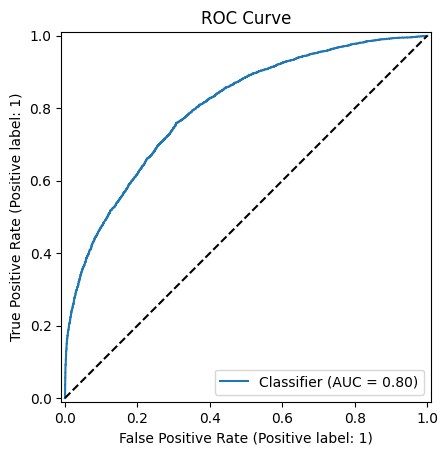

Second Model (Residual):
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report:
              precision    recall  f1-score   support

      Single       0.74      0.77      0.75      6345
    Multiple       0.70      0.66      0.68      5124

    accuracy                           0.72     11469
   macro avg       0.72      0.71      0.71     11469
weighted avg       0.72      0.72      0.72     11469


ROC AUC Score: 0.7961708648372989


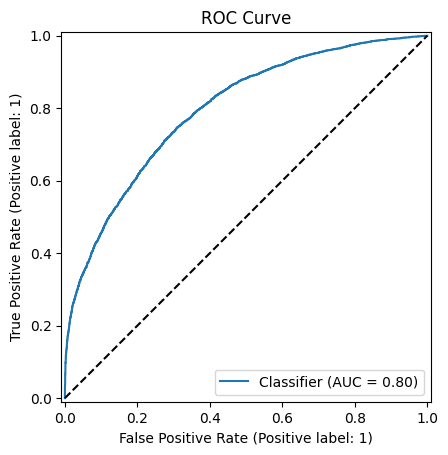

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    y_proba = model.predict(X_test).flatten()

    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Single', 'Multiple']))

    print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))

    # Plot ROC curve
    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.show()

print("First Model (Feedforward):")
evaluate_model(best_first_model, X_test, y_test)

print("Second Model (Residual):")
evaluate_model(best_second_model, X_test, y_test)

In [ ]:
# Save models
best_first_model.save('/content/drive/MyDrive/ACTL3143_project/best_first_model.keras')
best_second_model.save('/content/drive/MyDrive/ACTL3143_project/best_second_model.keras')

# Save tuner results
first_tuner.results_summary()
second_tuner.results_summary()

Results summary
Results in /content/drive/MyDrive/ACTL3143_project/tuning/first_model
Showing 10 best trials
Objective(name="val_auc", direction="max")

Trial 12 summary
Hyperparameters:
num_layers: 3
units_0: 192
dropout_0: 0.30000000000000004
lr: 0.0006562893605899151
units_1: 192
dropout_1: 0.1
units_2: 128
dropout_2: 0.5
units_3: 192
dropout_3: 0.30000000000000004
Score: 0.8006281852722168

Trial 14 summary
Hyperparameters:
num_layers: 3
units_0: 96
dropout_0: 0.5
lr: 0.0005673128375063142
units_1: 160
dropout_1: 0.4
units_2: 192
dropout_2: 0.5
units_3: 160
dropout_3: 0.4
Score: 0.7994522452354431

Trial 00 summary
Hyperparameters:
num_layers: 4
units_0: 224
dropout_0: 0.2
lr: 0.0004529223684351832
units_1: 32
dropout_1: 0.1
units_2: 32
dropout_2: 0.1
units_3: 32
dropout_3: 0.1
Score: 0.7990894913673401

Trial 07 summary
Hyperparameters:
num_layers: 2
units_0: 128
dropout_0: 0.4
lr: 0.0009606401217096411
units_1: 192
dropout_1: 0.5
units_2: 224
dropout_2: 0.4
units_3: 256
dropout_3